Preparamos Colab para trabajar con R

In [5]:
%%bash
apt-get install -y r-base


Reading package lists...
Building dependency tree...
Reading state information...
r-base is already the newest version (4.5.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [6]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Descargamos el dataset


In [7]:
%%shell
mkdir -p ~/.kaggle
cp /content/sample_data/kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

In [8]:
%%shell
pip install kaggle

In [9]:
%%shell
kaggle datasets download nisargpatel344/student-course-completion-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/nisargpatel344/student-course-completion-prediction-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/4.37M [00:00<?, ?B/s]
100% 4.37M/4.37M [00:00<00:00, 172MB/s]


In [10]:
%%R
system("unzip -o /content/student-course-completion-prediction-dataset.zip -d /content/")
df = read.csv("/content/Course_Completion_Prediction.csv")
head(df, 10)

   Student_ID            Name Gender Age Education_Level Employment_Status
1   STU100000    Vihaan Patel   Male  19         Diploma           Student
2   STU100001      Arjun Nair Female  17        Bachelor           Student
3   STU100002 Aditya Bhardwaj Female  34          Master           Student
4   STU100003   Krishna Singh Female  29         Diploma          Employed
5   STU100004    Krishna Nair Female  19          Master     Self-Employed
6   STU100005     Rohan Reddy Female  21        Bachelor           Student
7   STU100006        Sai Nair   Male  22         Diploma          Employed
8   STU100007   Krishna Desai   Male  23          Master          Employed
9   STU100008    Vihaan Joshi   Male  17        Bachelor           Student
10  STU100009     Vivaan Nair   Male  32        Bachelor           Student
        City Device_Type Internet_Connection_Quality Course_ID
1     Indore      Laptop                      Medium      C102
2      Delhi      Laptop                         

EDA

Dimensiones del dataset

In [11]:
%%R
dim(df)


[1] 100000     40


Tipos de datos

In [12]:
%%R
str(df)


'data.frame':	100000 obs. of  40 variables:
 $ Student_ID                  : chr  "STU100000" "STU100001" "STU100002" "STU100003" ...
 $ Name                        : chr  "Vihaan Patel" "Arjun Nair" "Aditya Bhardwaj" "Krishna Singh" ...
 $ Gender                      : chr  "Male" "Female" "Female" "Female" ...
 $ Age                         : int  19 17 34 29 19 21 22 23 17 32 ...
 $ Education_Level             : chr  "Diploma" "Bachelor" "Master" "Diploma" ...
 $ Employment_Status           : chr  "Student" "Student" "Student" "Employed" ...
 $ City                        : chr  "Indore" "Delhi" "Chennai" "Surat" ...
 $ Device_Type                 : chr  "Laptop" "Laptop" "Mobile" "Mobile" ...
 $ Internet_Connection_Quality : chr  "Medium" "Low" "Medium" "High" ...
 $ Course_ID                   : chr  "C102" "C106" "C101" "C105" ...
 $ Course_Name                 : chr  "Data Analysis with Python" "Machine Learning A-Z" "Python Basics" "UI/UX Design Fundamentals" ...
 $ Category   

Resúmen estadístico

In [13]:
%%R
summary(df)


  Student_ID            Name              Gender               Age       
 Length:100000      Length:100000      Length:100000      Min.   :17.00  
 Class :character   Class :character   Class :character   1st Qu.:21.00  
 Mode  :character   Mode  :character   Mode  :character   Median :25.00  
                                                          Mean   :25.71  
                                                          3rd Qu.:30.00  
                                                          Max.   :52.00  
 Education_Level    Employment_Status      City           Device_Type       
 Length:100000      Length:100000      Length:100000      Length:100000     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                    

Revisar valores faltantes

In [14]:
%%R
colSums(is.na(df))


                  Student_ID                         Name 
                           0                            0 
                      Gender                          Age 
                           0                            0 
             Education_Level            Employment_Status 
                           0                            0 
                        City                  Device_Type 
                           0                            0 
 Internet_Connection_Quality                    Course_ID 
                           0                            0 
                 Course_Name                     Category 
                           0                            0 
                Course_Level         Course_Duration_Days 
                           0                            0 
           Instructor_Rating              Login_Frequency 
                           0                            0 
Average_Session_Duration_Min        Video_Completion_Rat

Distribución de la variable objetivo

In [15]:
%%R
table(df$Completed)



    Completed Not Completed 
        49030         50970 


Feature Engineering

Conversión de datos


In [16]:
%%R
library(dplyr)
library(lubridate)
# --- 1. Convertir la variable objetivo a binaria ---
df <- df %>%
  mutate(
    Completed_Flag = ifelse(Completed == "Completed", 1, 0)
  )

# --- 2. Convertir Enrollment_Date a formato fecha ---
df <- df %>%
  mutate(
    Enrollment_Date = dmy(Enrollment_Date)
  )



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



In [17]:
%%R
# --- 3. Antigüedad del alumno en la plataforma ---
df <- df %>%
  mutate(
    Days_Active = as.numeric(Sys.Date() - Enrollment_Date)
  )

In [18]:
%%R
# --- 4. Motivación total ---
df <- df %>%
  mutate(
    Total_Engagement =
      Login_Frequency +
      (Average_Session_Duration_Min / 10) +
      (Video_Completion_Rate / 20) +
      Discussion_Participation +
      Peer_Interaction_Score +
      (Time_Spent_Hours / 2) +
      Notifications_Checked +
      (App_Usage_Percentage / 10)
  )

In [19]:
%%R
# --- 5. Ratio de tareas entregadas ---
df <- df %>%
  mutate(
    Assignment_Ratio = Assignments_Submitted / (Assignments_Submitted + Assignments_Missed + 1)
  )

In [20]:
%%R
# --- 6. Éxito aproximado en quizzes ---
df <- df %>%
  mutate(
    Quiz_Success_Rate = Quiz_Score_Avg / 100
  )

In [21]:
%%R
# --- 7. Rendimiento académico global ---
df <- df %>%
  mutate(
    Overall_Performance =
      0.4 * Quiz_Score_Avg +
      0.4 * Project_Grade +
      0.2 * Progress_Percentage
  )

In [22]:
%%R
# --- 8. Motivación por día de curso ---
df <- df %>%
  mutate(
    Engagement_per_Day = Total_Engagement / (Course_Duration_Days + 1)
  )

In [23]:
%%R

# --- 9. Riesgo por inactividad ---
df <- df %>%
  mutate(
    Inactivity_Risk = Days_Since_Last_Login / (Login_Frequency + 1)
  )


In [24]:
%%R
# --- 10. Columnas binarias de pago y descuento ---
df <- df %>%
  mutate(
    Discount_Flag = ifelse(Discount_Used == "Yes", 1, 0),
    Fee_Paid_Flag = ifelse(Fee_Paid == "Yes", 1, 0)
  )

In [25]:
%%R
# --- 11. Mapeo del nivel del curso ---
df <- df %>%
  mutate(
    Difficulty_Score = case_when(
      Course_Level == "Beginner" ~ 1,
      Course_Level == "Intermediate" ~ 2,
      Course_Level == "Advanced" ~ 3,
      TRUE ~ 2
    )
  )

In [26]:
%%R
# --- 12. Puntuación de interacción técnica ---
df <- df %>%
  mutate(
    Platform_Interaction_Index =
      Rewatch_Count +
      Reminder_Emails_Clicked +
      Support_Tickets_Raised
  )

In [27]:
%%R
# --- 13. Puntuación estimada de motivación ---
df <- df %>%
  mutate(
    Motivation_Score =
      0.3 * Peer_Interaction_Score +
      0.3 * Discussion_Participation +
      0.4 * Satisfaction_Rating
  )

In [38]:
%%R
# --- 14. Horas de estudio ---
df$Hours_Studied <- df$Time_Spent_Hours + (df$Average_Session_Duration_Min / 60)


In [28]:
%%R
head(df, 10)

   Student_ID            Name Gender Age Education_Level Employment_Status
1   STU100000    Vihaan Patel   Male  19         Diploma           Student
2   STU100001      Arjun Nair Female  17        Bachelor           Student
3   STU100002 Aditya Bhardwaj Female  34          Master           Student
4   STU100003   Krishna Singh Female  29         Diploma          Employed
5   STU100004    Krishna Nair Female  19          Master     Self-Employed
6   STU100005     Rohan Reddy Female  21        Bachelor           Student
7   STU100006        Sai Nair   Male  22         Diploma          Employed
8   STU100007   Krishna Desai   Male  23          Master          Employed
9   STU100008    Vihaan Joshi   Male  17        Bachelor           Student
10  STU100009     Vivaan Nair   Male  32        Bachelor           Student
        City Device_Type Internet_Connection_Quality Course_ID
1     Indore      Laptop                      Medium      C102
2      Delhi      Laptop                         

Gráficos


In [29]:
%%R
library(ggplot2)
library(dplyr)


Distribución de alumnos que completaron vs. no completaron

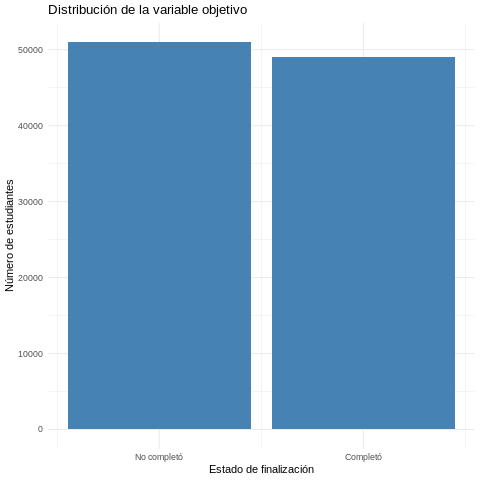

In [30]:
%%R
ggplot(df, aes(x = Completed_Flag)) +
  geom_bar(fill = "steelblue") +
  scale_x_continuous(breaks = c(0,1), labels = c("No completó", "Completó")) +
  labs(title = "Distribución de la variable objetivo",
       x = "Estado de finalización",
       y = "Número de estudiantes") +
  theme_minimal()


Distribución de la edad de los estudiantes

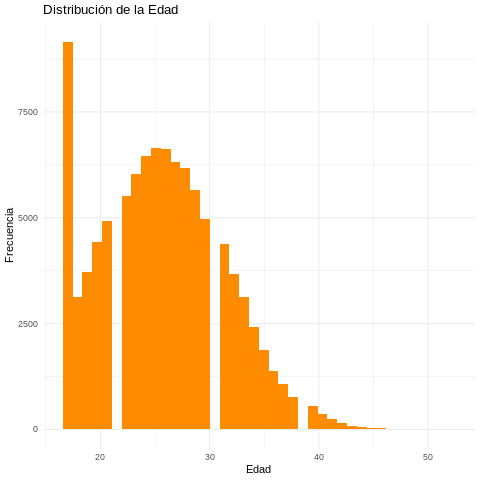

In [31]:
%%R
ggplot(df, aes(x = Age)) +
  geom_histogram(bins = 40, fill = "darkorange") +
  labs(title = "Distribución de la Edad",
       x = "Edad",
       y = "Frecuencia") +
  theme_minimal()


Proporción de finalización por género

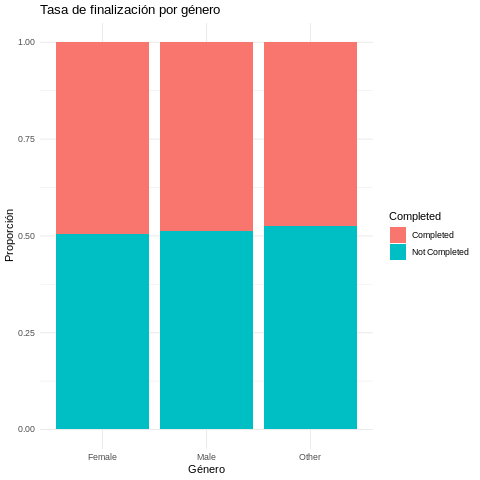

In [32]:
%%R
ggplot(df, aes(x = Gender, fill = Completed)) +
  geom_bar(position = "fill") +
  labs(title = "Tasa de finalización por género",
       x = "Género",
       y = "Proporción") +
  theme_minimal()


Distribución del desempeño global


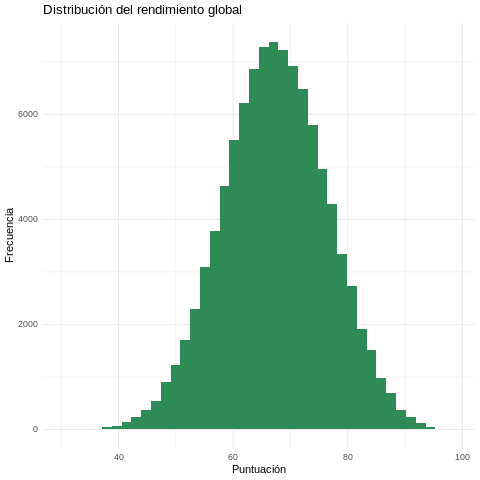

In [33]:
%%R
ggplot(df, aes(x = Overall_Performance)) +
  geom_histogram(bins = 40, fill = "seagreen") +
  labs(title = "Distribución del rendimiento global",
       x = "Puntuación",
       y = "Frecuencia") +
  theme_minimal()


Comparación horas estudio - rendimiento

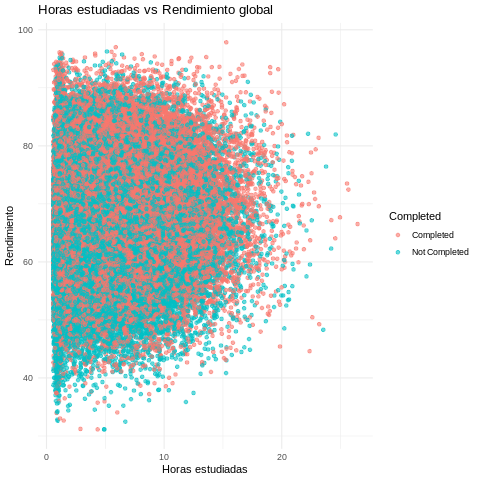

In [39]:
%%R
ggplot(df, aes(x = Hours_Studied, y = Overall_Performance, color = Completed)) +
  geom_point(alpha = 0.6) +
  labs(title = "Horas estudiadas vs Rendimiento global",
       x = "Horas estudiadas",
       y = "Rendimiento") +
  theme_minimal()

Comparación de Motivation Score por género

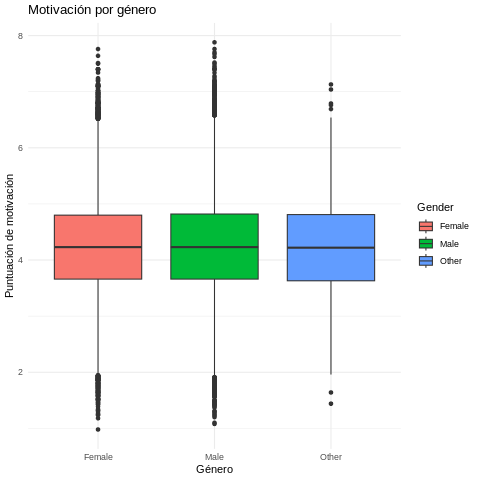

In [44]:
%%R
ggplot(df, aes(x = Gender, y = Motivation_Score, fill = Gender)) +
  geom_boxplot() +
  labs(title = "Motivación por género",
       x = "Género",
       y = "Puntuación de motivación") +
  theme_minimal()


Motivation Score vs Performance

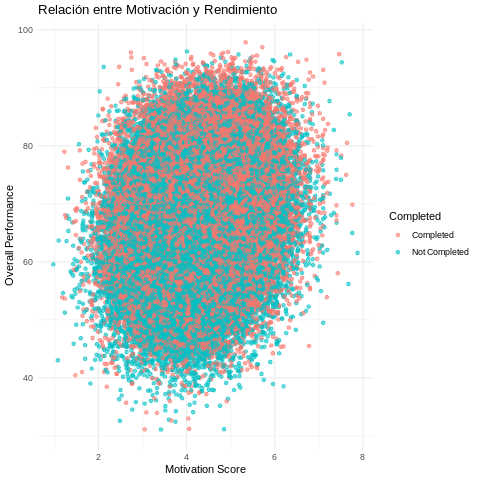

In [45]:
%%R
ggplot(df, aes(x = Motivation_Score, y = Overall_Performance, color = Completed)) +
  geom_point(alpha = 0.6) +
  labs(title = "Relación entre Motivación y Rendimiento",
       x = "Motivation Score",
       y = "Overall Performance") +
  theme_minimal()
